<a href="https://colab.research.google.com/github/maxaragon/Hurricanes/blob/master/HURDAT2_Max.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install missing packages

In [73]:
!pip install scipy>=1.7.1
!pip install matplotlib>=3.4.3
!pip install dython
!pip install --upgrade ipython
!pip install geopy
!pip install gdown
!pip install geopandas



# Restart runtime! then import the packages

In [1]:
import os
import datetime
import matplotlib as mpl
import pandas as pd
import seaborn as sns
import numpy as np
import geopy.distance
import geopandas as gpd
import matplotlib.pyplot as plt
from dython import nominal
from geopandas import GeoDataFrame
from shapely.geometry import Point
from shapely.geometry import LineString
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

mpl.rcParams['figure.figsize'] = (10,8)
mpl.rcParams['axes.grid'] = False

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
print(tf.__version__)
print(tf.test.gpu_device_name())
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2.8.0
/device:GPU:0
Num GPUs Available:  1


Load dataset

In [3]:
!git clone https://github.com/maxaragon/Hurricanes.git

Cloning into 'Hurricanes'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 14 (delta 0), reused 6 (delta 0), pack-reused 8
Unpacking objects: 100% (14/14), done.


In [4]:
cd Hurricanes

/content/Hurricanes


In [5]:
!ls

atlantic.csv  README.md


Initial inspection

In [6]:
dataset = pd.read_csv('atlantic.csv')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49105 entries, 0 to 49104
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   ID                49105 non-null  object
 1   Name              49105 non-null  object
 2   Date              49105 non-null  int64 
 3   Time              49105 non-null  int64 
 4   Event             49105 non-null  object
 5   Status            49105 non-null  object
 6   Latitude          49105 non-null  object
 7   Longitude         49105 non-null  object
 8   Maximum Wind      49105 non-null  int64 
 9   Minimum Pressure  49105 non-null  int64 
 10  Low Wind NE       49105 non-null  int64 
 11  Low Wind SE       49105 non-null  int64 
 12  Low Wind SW       49105 non-null  int64 
 13  Low Wind NW       49105 non-null  int64 
 14  Moderate Wind NE  49105 non-null  int64 
 15  Moderate Wind SE  49105 non-null  int64 
 16  Moderate Wind SW  49105 non-null  int64 
 17  Moderate Win

In [7]:
dataset.memory_usage(deep=True)

Index                   128
ID                  3191825
Name                3731980
Date                 392840
Time                 392840
Event               2897195
Status              2946300
Latitude            3044281
Longitude           3044517
Maximum Wind         392840
Minimum Pressure     392840
Low Wind NE          392840
Low Wind SE          392840
Low Wind SW          392840
Low Wind NW          392840
Moderate Wind NE     392840
Moderate Wind SE     392840
Moderate Wind SW     392840
Moderate Wind NW     392840
High Wind NE         392840
High Wind SE         392840
High Wind SW         392840
High Wind NW         392840
dtype: int64

In [8]:
dataset.describe()

,Date,Time,Maximum Wind,Minimum Pressure,Low Wind NE,Low Wind SE,Low Wind SW,Low Wind NW,Moderate Wind NE,Moderate Wind SE,Moderate Wind SW,Moderate Wind NW,High Wind NE,High Wind SE,High Wind SW,High Wind NW
count,4.910500e+04,49105.000000,49105.000000,49105.000000,49105.000000,49105.000000,49105.000000,49105.000000,49105.000000,49105.000000,49105.000000,49105.000000,49105.000000,49105.000000,49105.000000,49105.000000
mean,1.949802e+07,910.125975,52.005091,-251.406496,-868.671031,-869.315772,-872.676428,-871.409245,-875.570940,-875.765319,-876.682028,-876.323205,-877.564321,-877.655045,-877.923552,-877.786295
std,4.461850e+05,671.043363,27.681902,964.313907,353.299666,351.548910,342.153768,345.628984,333.651396,333.133376,330.526085,331.535176,328.027275,327.774794,327.021430,327.408253
min,1.851062e+07,0.000000,-99.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000
25%,1.911110e+07,600.000000,35.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000
50%,1.956093e+07,1200.000000,45.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000
75%,1.989081e+07,1800.000000,70.000000,990.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000
max,2.015111e+07,2330.000000,165.000000,1024.000000,710.000000,600.000000,640.000000,530.000000,360.000000,300.000000,330.000000,360.000000,180.000000,250.000000,150.000000,180.000000


General cleaning

In [9]:
def clean(dataset):
    '''Removes NaN values, removes rows with inconsistent times (e.g 2200, 1430), joins date and time, 
       and converts coordinates into decimal degrees '''
    # Read csv file, assign -999 as NaN values
    df = pd.read_csv(dataset,  index_col='ID', na_values=-999)
    # Remove NaN rows
    df.dropna(axis=0, how='any', inplace=True)
    df.Time = df.Time.astype(str)
    # Select only rows with similar times (0,6,12,18)
    df = df.loc[(df.Time=='0') | (df.Time=='600') | (df.Time =='1200') | (df.Time == '1800')]
    # Modify length of time values
    df.loc[(df.Time=='0'), 'Time'] = '00'
    df.loc[(df.Time=='600'), 'Time'] = '06'
    df.loc[(df.Time=='1200'), 'Time'] = '12'
    df.loc[(df.Time=='1800'), 'Time'] = '18'
    # Join Date and Time columns
    df.Date = df.Date.astype(str)
    df['Datetime'] = df.Date + df.Time
    df.Datetime =  pd.to_datetime(df.Datetime, format='%Y%m%d%H')
    df = df.drop(columns=['Date', 'Time', 'Event'])
    # Insert column 'Datetime' to first position after index (ID)
    Datetime = df.pop('Datetime')
    df.insert(1, 'Datetime', Datetime)
    # Convert into decimal degrees
    df.loc[df.Longitude.str.contains('W'), 'Longitude'] = '-' + df.Longitude[df.Longitude.str.contains('W')]
    df.Longitude = df.Longitude.replace('E', '', regex=True) 
    df.Longitude = df.Longitude.replace('W', '', regex=True) 
    df.Longitude = df.Longitude.astype(float)
    df.Latitude = df.Latitude.replace('N', '', regex=True) 
    df.Latitude = df.Latitude.astype(float)
    return df

In [10]:
df = clean('atlantic.csv')
df.head()

,Name,Datetime,Status,Latitude,Longitude,Maximum Wind,Minimum Pressure,Low Wind NE,Low Wind SE,Low Wind SW,Low Wind NW,Moderate Wind NE,Moderate Wind SE,Moderate Wind SW,Moderate Wind NW,High Wind NE,High Wind SE,High Wind SW,High Wind NW
ID,,,,,,,,,,,,,,,,,,,
AL012004,ALEX,2004-07-31 18:00:00,TD,30.3,-78.3,25,1010.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AL012004,ALEX,2004-08-01 00:00:00,TD,31.0,-78.8,25,1009.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AL012004,ALEX,2004-08-01 06:00:00,TD,31.5,-79.0,25,1009.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AL012004,ALEX,2004-08-01 12:00:00,TD,31.6,-79.1,30,1009.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AL012004,ALEX,2004-08-01 18:00:00,TS,31.6,-79.2,35,1009.0,0.0,50.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
# Make all the trajectories match a multiple of 5 (and remove trajectories with less than 5 data points)

def new_values(df):
  while not len(df) % 5 == 0:
    df = df.iloc[:-1]
  return df

df = df.groupby('ID').apply(new_values) 
print(df.groupby('ID').size())

ID
AL012004    25
AL012005    20
AL012006    35
AL012007    30
AL012008     5
            ..
AL272005    15
AL282005    30
AL292005    40
AL302005    40
AL312005    35
Length: 196, dtype: int64


In [12]:
# Number of unique trajectories 

print(len(df.index.unique()))

196


In [13]:
# Mean and avg number of data points accros trajectories

count = df.groupby('ID').size()

print(f'Mean count = {count.mean(): .2f}')
print(f'Median count = {count.median(): .2f}')

Mean count =  27.65
Median count =  25.00


<AxesSubplot:title={'center':'Frequency of categories'}>

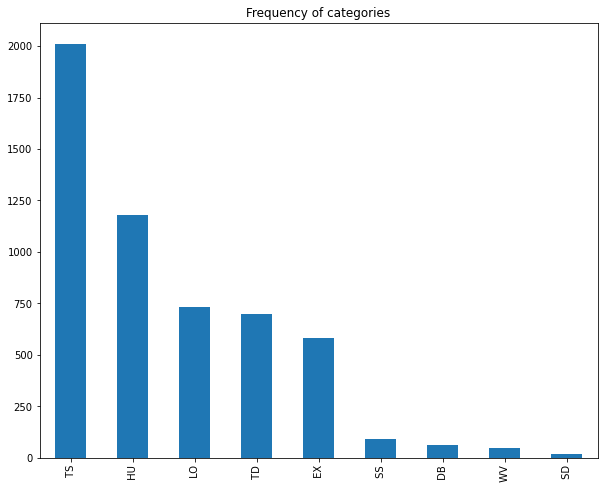

In [14]:
df['Status'].value_counts().plot(kind='bar', title='Frequency of categories')

<AxesSubplot:xlabel='Datetime'>

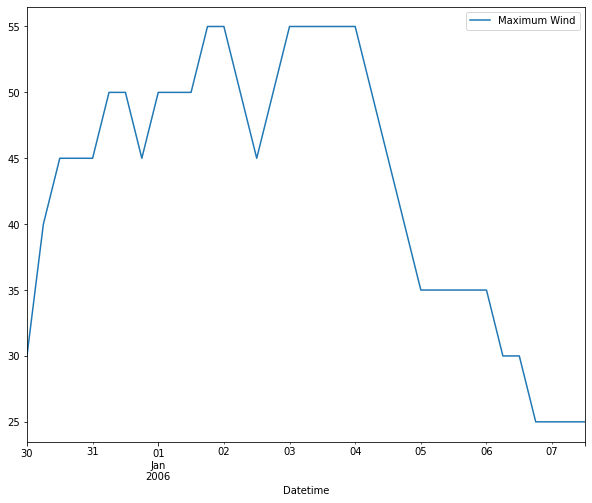

In [15]:
#Single event

s = df.groupby('ID').get_group('AL312005')

s.set_index('Datetime').plot(y='Maximum Wind')

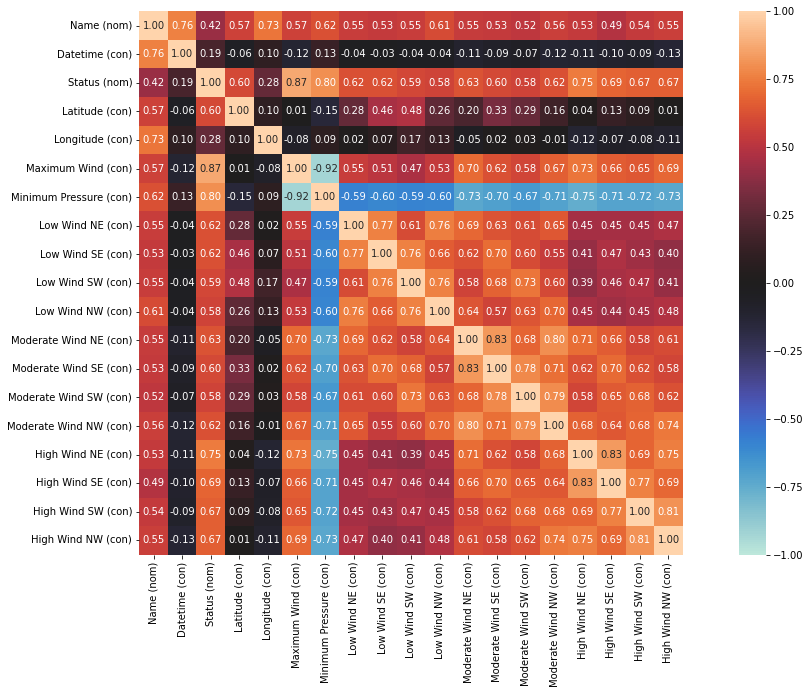

In [16]:
nominal.associations(df,figsize=(20,10),mark_columns=True);
plt.show()

In [17]:
# Find correlation among features for Max wind
cor = df.corr(method='pearson')
cor_target = abs(cor['Maximum Wind'])
relevant_features = cor_target[cor_target>0.65]
relevant_features.sort_values(ascending=False)

Maximum Wind        1.000000
Minimum Pressure    0.924674
High Wind NE        0.729588
Moderate Wind NE    0.695557
High Wind NW        0.688441
Moderate Wind NW    0.668033
High Wind SE        0.661029
Name: Maximum Wind, dtype: float64

In [18]:
df1 = df[['Maximum Wind', 'Minimum Pressure', 'Moderate Wind NE', 'Moderate Wind NW', 'High Wind NE', 'High Wind SE', 'High Wind NW']]

df1.corr(method='pearson')

,Maximum Wind,Minimum Pressure,Moderate Wind NE,Moderate Wind NW,High Wind NE,High Wind SE,High Wind NW
Maximum Wind,1.000000,-0.924674,0.695557,0.668033,0.729588,0.661029,0.688441
Minimum Pressure,-0.924674,1.000000,-0.729340,-0.710910,-0.754009,-0.712996,-0.732651
Moderate Wind NE,0.695557,-0.729340,1.000000,0.803535,0.708070,0.660680,0.606813
Moderate Wind NW,0.668033,-0.710910,0.803535,1.000000,0.675561,0.641782,0.740980
High Wind NE,0.729588,-0.754009,0.708070,0.675561,1.000000,0.832483,0.750556
High Wind SE,0.661029,-0.712996,0.660680,0.641782,0.832483,1.000000,0.689626
High Wind NW,0.688441,-0.732651,0.606813,0.740980,0.750556,0.689626,1.000000


In [105]:
df_select = df[[ 'Datetime', 'Latitude', 'Longitude', 'Maximum Wind', 'Minimum Pressure', 'Moderate Wind NE', 'High Wind NE', 'High Wind NW']]

df_select.head()

Datetime  Latitude  Longitude  Maximum Wind  \
ID       ID                                                                
AL012004 AL012004 2004-07-31 18:00:00      30.3      -78.3            25   
         AL012004 2004-08-01 00:00:00      31.0      -78.8            25   
         AL012004 2004-08-01 06:00:00      31.5      -79.0            25   
         AL012004 2004-08-01 12:00:00      31.6      -79.1            30   
         AL012004 2004-08-01 18:00:00      31.6      -79.2            35   

                   Minimum Pressure  Moderate Wind NE  High Wind NE  \
ID       ID                                                           
AL012004 AL012004            1010.0               0.0           0.0   
         AL012004            1009.0               0.0           0.0   
         AL012004            1009.0               0.0           0.0   
         AL012004            1009.0               0.0           0.0   
         AL012004            1009.0               0.0           0.0   

                   High Wind NW  
ID       ID                      
AL012004 AL012004           0.0  
         AL012004           0.0  
         AL012004           0.0  
         AL012004           0.0  
         AL012004           0.0

([], [])

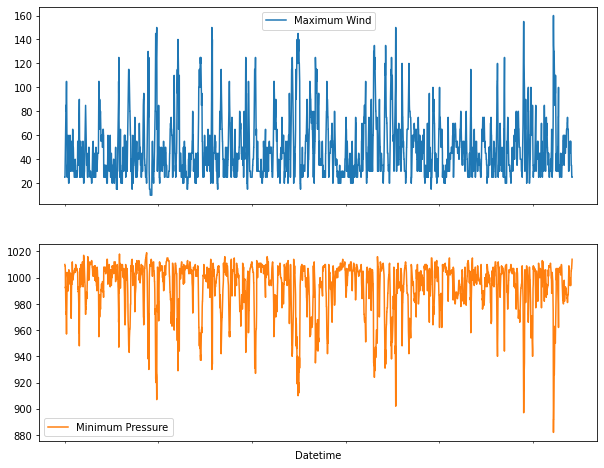

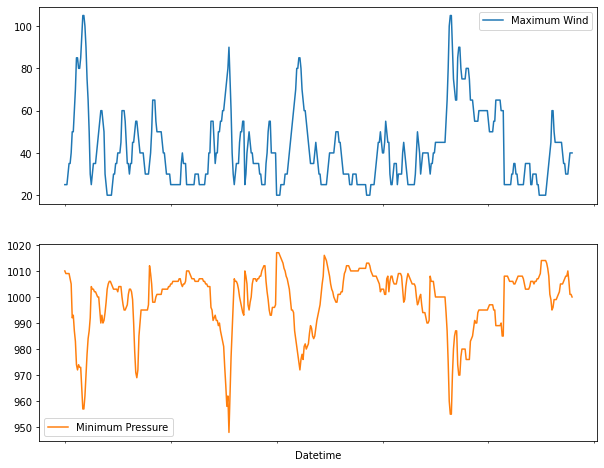

In [106]:
#Plot the time series

df_select.set_index('Datetime', inplace=True)
#df_select.index = df_select.index.strftime('%Y')
df_select.index = df_select.index.astype(str)

plot_cols = ['Maximum Wind', 'Minimum Pressure']
plot_features = df_select[plot_cols]
_ = plot_features.plot(subplots=True); plt.xticks([])




#Closer look
plot_features = df_select[plot_cols][:480]
_ = plot_features.plot(subplots=True); plt.xticks([])

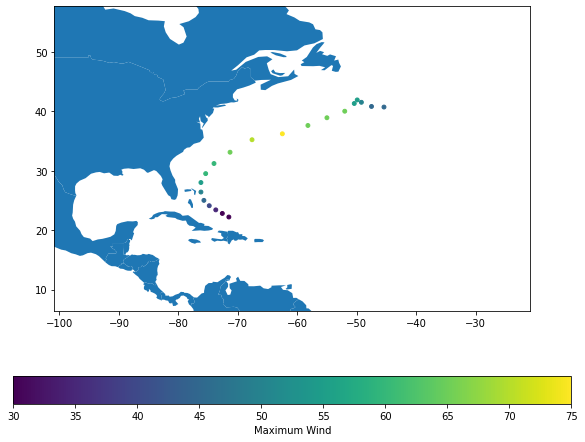

In [21]:
def show_hurricane(ID):
    HU = df.loc[ID]
    geometry = [Point(xy) for xy in zip(HU['Longitude'], HU['Latitude'])]
    gdf = GeoDataFrame(HU, geometry=geometry)  
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

    ax = gdf.plot(ax=world.plot(figsize=(10, 8)), 
             marker='o', markersize=15, 
             column='Maximum Wind', 
             legend=True, 
             legend_kwds={'label': "Maximum Wind",'orientation': "horizontal"})
    
    margin_y = .8  # margin on y axis as a ratio of y extent
    margin_x = .8  # margin on x axis as a ratio of y extent

    xmin, ymin, xmax, ymax = gdf.total_bounds
    y_margin = (ymax - ymin) * margin_y
    x_margin = (xmax - xmin) * margin_x


    ax.set_xlim(xmin - x_margin, xmax + x_margin)
    ax.set_ylim(ymin - y_margin, ymax + y_margin)
             

show_hurricane('AL122015')

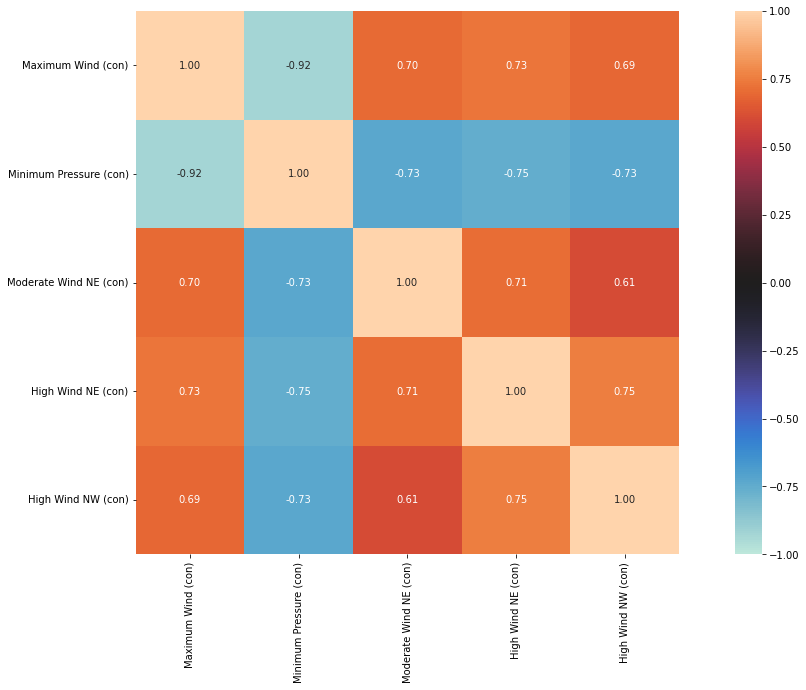

In [22]:
d2 = df[['Maximum Wind', 'Minimum Pressure', 'Moderate Wind NE', 'High Wind NE', 'High Wind NW']]

nominal.associations(d2,figsize=(20,10),mark_columns=True);
plt.show()

LSTM data preparation 

In [23]:
# Target feature
max_wind = d2['Maximum Wind']; max_wind = np.array(max_wind)

# Features for prediction
raw_data = d2[['Maximum Wind', 'Minimum Pressure', 'Moderate Wind NE', 'High Wind NE', 'High Wind NW']]; raw_data = np.array(raw_data)

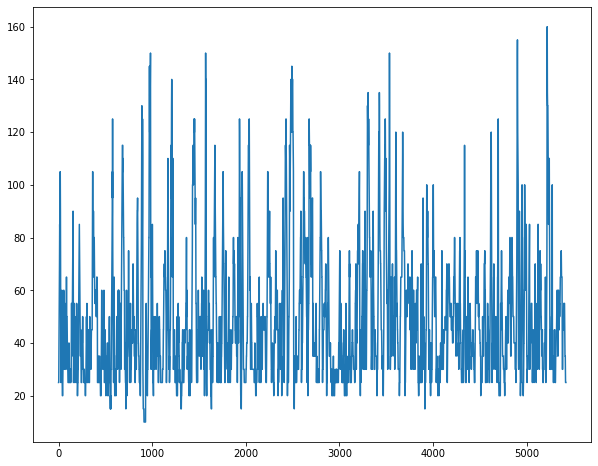

In [24]:
# Entire time series (2004, 2015)
plt.plot(range(len(max_wind)), max_wind)

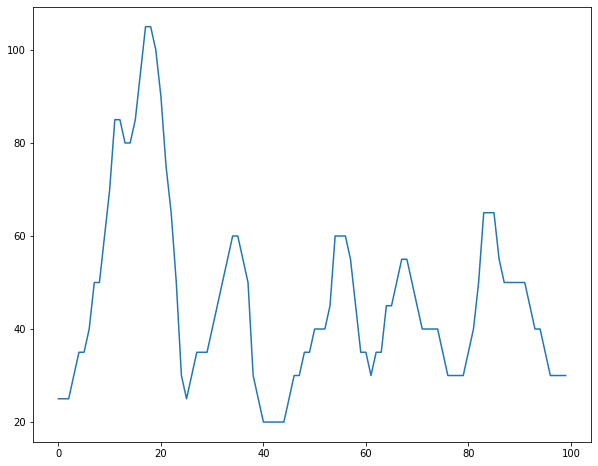

In [25]:
# Closer look, 4 events
plt.plot(range(100), max_wind[:100])

In [26]:
# Train, validation and test samples

num_train_samples = int(0.6 * len(raw_data))
num_val_samples = int(0.20 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples

print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 3252
num_val_samples: 1084
num_test_samples: 1084


In [27]:
# Data normalization
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [28]:
sampling_rate = 2 
sequence_length = 150 #Assumes 6 trajectories
delay = sampling_rate * (sequence_length + 25 - 1) #Predict the next trajectory
batch_size = 256

In [29]:
# Instantiating dataset for training, validation and testing

# Timeseries_dataset_from_array creates a dataset of sliding windows over a timeseries provided as array

train_dataset = keras.utils.timeseries_dataset_from_array(
 raw_data[:-delay],
 targets=max_wind[delay:],
 sampling_rate=sampling_rate,
 sequence_length=sequence_length,
 shuffle=True,
 batch_size=batch_size,
 start_index=0,
 end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
 raw_data[:-delay],
 targets=max_wind[delay:],
 sampling_rate=sampling_rate,
 sequence_length=sequence_length,
 shuffle=True,
 batch_size=batch_size,
 start_index=num_train_samples,
 end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
 raw_data[:-delay],
 targets=max_wind[delay:],
 sampling_rate=sampling_rate,
 sequence_length=sequence_length,
 shuffle=True,
 batch_size=batch_size,
 start_index=num_train_samples + num_val_samples)

In [30]:
for samples, targets in train_dataset:
  print("samples shape:", samples.shape)
  print("targets shape:", targets.shape)
  break


samples shape: (256, 150, 5)
targets shape: (256,)


In [31]:
#physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

Epoch 1/10
12/12 [==============================] - 8s 112ms/step - loss: 3081.5544 - mae: 48.9249 - val_loss: 2692.7375 - val_mae: 48.3356
Epoch 2/10
12/12 [==============================] - 1s 60ms/step - loss: 3045.3962 - mae: 48.5484 - val_loss: 2635.3770 - val_mae: 47.7433
Epoch 3/10
12/12 [==============================] - 1s 59ms/step - loss: 2949.0435 - mae: 47.5346 - val_loss: 2513.6477 - val_mae: 46.4464
Epoch 4/10
12/12 [==============================] - 1s 60ms/step - loss: 2844.9814 - mae: 46.4360 - val_loss: 2436.4678 - val_mae: 45.6056
Epoch 5/10
12/12 [==============================] - 1s 58ms/step - loss: 2782.0615 - mae: 45.7573 - val_loss: 2384.0425 - val_mae: 45.0235
Epoch 6/10
12/12 [==============================] - 1s 58ms/step - loss: 2734.6230 - mae: 45.2362 - val_loss: 2340.5488 - val_mae: 44.5345
Epoch 7/10
12/12 [==============================] - 1s 60ms/step - loss: 2691.4229 - mae: 44.7610 - val_loss: 2300.3660 - val_mae: 44.0829
Epoch 8/10
12/12 [========

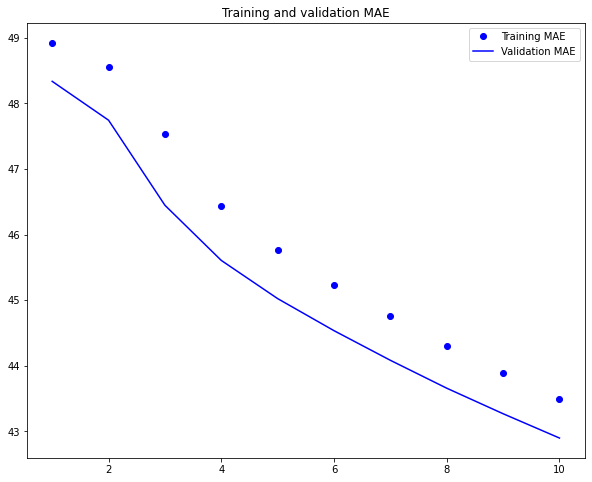

In [32]:
# Baseline LSTM model

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
callbacks = [
 keras.callbacks.ModelCheckpoint("atlantic_lstm.keras",
 save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
 epochs=10,
 validation_data=val_dataset,
 callbacks=callbacks)
model = keras.models.load_model("atlantic_lstm.keras") 
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

Epoch 1/50
12/12 [==============================] - 14s 937ms/step - loss: 3053.5938 - mae: 48.6298 - val_loss: 2649.6150 - val_mae: 47.8624
Epoch 2/50
12/12 [==============================] - 9s 692ms/step - loss: 2893.3516 - mae: 46.9420 - val_loss: 2398.5293 - val_mae: 45.1352
Epoch 3/50
12/12 [==============================] - 9s 702ms/step - loss: 2678.6936 - mae: 44.6358 - val_loss: 2218.0349 - val_mae: 43.1345
Epoch 4/50
12/12 [==============================] - 9s 705ms/step - loss: 2542.7849 - mae: 43.0737 - val_loss: 2125.3313 - val_mae: 42.0539
Epoch 5/50
12/12 [==============================] - 9s 691ms/step - loss: 2464.3745 - mae: 42.1354 - val_loss: 2054.4392 - val_mae: 41.2049
Epoch 6/50
12/12 [==============================] - 9s 694ms/step - loss: 2395.5007 - mae: 41.2915 - val_loss: 1994.4326 - val_mae: 40.4703
Epoch 7/50
12/12 [==============================] - 9s 721ms/step - loss: 2343.7688 - mae: 40.6130 - val_loss: 1943.1031 - val_mae: 39.8310
Epoch 8/50
12/12 [=

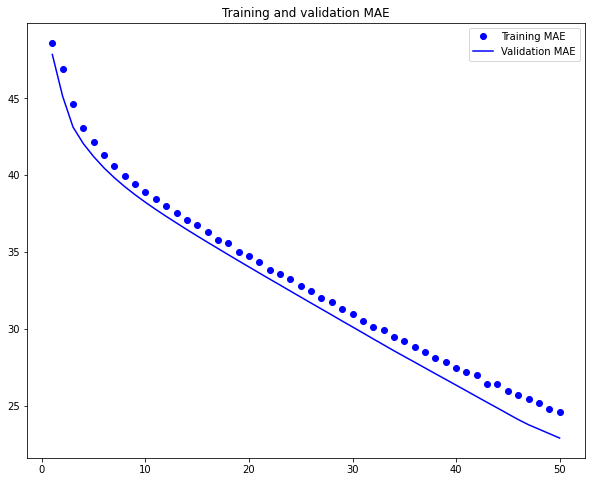

In [33]:
# Second baseline model

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
callbacks = [
 keras.callbacks.ModelCheckpoint("atlantic_lstm_dropout.keras",
 save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
 epochs=50,
 validation_data=val_dataset,
 callbacks=callbacks) 
model = keras.models.load_model("atlantic_lstm_dropout.keras") 
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [34]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 5)]          0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                4864      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,897
Trainable params: 4,897
Non-trainable params: 0
_________________________________________________________________


In [35]:
model.evaluate(test_dataset, verbose=0)

[1088.5631103515625, 24.053266525268555]

Third LSTM

In [36]:
d3 = df[['Maximum Wind', 'Minimum Pressure', 'Moderate Wind NE', 'High Wind NE', 'High Wind NW']]

In [37]:
# Normalization

s1 = MinMaxScaler(feature_range=(0,1))
features = s1.fit_transform(d3[['Maximum Wind', 'Minimum Pressure',  'Moderate Wind NE', 'High Wind NE', 'High Wind NW']])

s2 = MinMaxScaler(feature_range=(0,1))
target = s2.fit_transform(d3[['Maximum Wind']])

In [38]:
#TimeseriesGenerator(features, target, length=125, sampling_rate=2, batch_size=256)

In [39]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.20, random_state=123, shuffle = False)

In [40]:
print("num_train_samples and features:", x_train.shape)
print("num_test_samples and features:", x_test.shape)

num_train_samples and features: (4336, 5)
num_test_samples and features: (1084, 5)


In [41]:
win_length = 125
batch_size = 256
num_features = 5
train_generator = TimeseriesGenerator(x_train, y_train, length=win_length, sampling_rate=1, batch_size=batch_size)
test_generator = TimeseriesGenerator(x_train, y_train, length=win_length, sampling_rate=1, batch_size=batch_size)

In [42]:
#inputs = keras.inputs(shape=(None, num_features)

model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(128, input_shape=(win_length, num_features) , return_sequences=True))
model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
model.add(tf.keras.layers.LSTM(128, return_sequences=True))
model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.LSTM(64, return_sequences=False))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(1))

In [43]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 125, 128)          68608     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 125, 128)          0         
                                                                 
 lstm_3 (LSTM)               (None, 125, 128)          131584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 125, 128)          0         
                                                                 
 dropout_1 (Dropout)         (None, 125, 128)          0         
                                                                 
 lstm_4 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0

Epoch 1/50
17/17 [==============================] - 11s 294ms/step - loss: 0.0408 - mae: 0.1505 - val_loss: 0.0215 - val_mae: 0.1092
Epoch 2/50
17/17 [==============================] - 3s 206ms/step - loss: 0.0242 - mae: 0.1156 - val_loss: 0.0176 - val_mae: 0.1000
Epoch 3/50
17/17 [==============================] - 3s 208ms/step - loss: 0.0196 - mae: 0.1048 - val_loss: 0.0151 - val_mae: 0.0953
Epoch 4/50
17/17 [==============================] - 3s 204ms/step - loss: 0.0173 - mae: 0.0990 - val_loss: 0.0130 - val_mae: 0.0878
Epoch 5/50
17/17 [==============================] - 3s 204ms/step - loss: 0.0155 - mae: 0.0928 - val_loss: 0.0117 - val_mae: 0.0852
Epoch 6/50
17/17 [==============================] - 3s 205ms/step - loss: 0.0125 - mae: 0.0851 - val_loss: 0.0114 - val_mae: 0.0832
Epoch 7/50
17/17 [==============================] - 3s 205ms/step - loss: 0.0126 - mae: 0.0843 - val_loss: 0.0096 - val_mae: 0.0758
Epoch 8/50
17/17 [==============================] - 3s 206ms/step - loss: 0

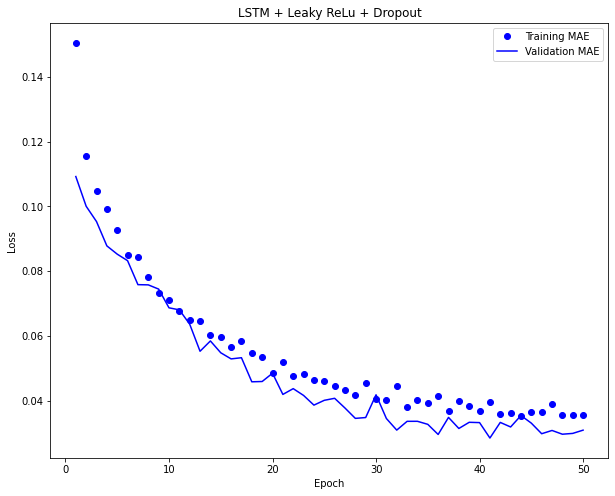

In [44]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=2,mode='min')

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(train_generator, epochs=50,validation_data=test_generator,shuffle=False)


loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("LSTM + Leaky ReLu + Dropout")
plt.legend()
plt.show()

In [45]:
model.evaluate(test_generator, verbose=0)

[0.002003001281991601, 0.03089636005461216]

In [58]:
predictions=model.predict(test_generator)
predictions.shape

(4211, 1)

In [48]:
x_test[:,1:][win_length:]

array([[0.74452555, 0.13888889, 0.        , 0.        ],
       [0.68613139, 0.13888889, 0.        , 0.        ],
       [0.69343066, 0.13888889, 0.13888889, 0.        ],
       ...,
       [0.9270073 , 0.        , 0.        , 0.        ],
       [0.94890511, 0.        , 0.        , 0.        ],
       [0.96350365, 0.        , 0.        , 0.        ]])

In [49]:
df_pred=pd.concat([pd.DataFrame(predictions), pd.DataFrame(x_test[:,1:][win_length:])],axis=1)

In [50]:
rev_trans=s1.inverse_transform(df_pred); rev_trans

array([[ 33.69912937, 984.        ,  50.        ,   0.        ,
          0.        ],
       [ 33.08371663, 976.        ,  50.        ,   0.        ,
          0.        ],
       [ 32.93046415, 977.        ,  50.        ,  25.        ,
          0.        ],
       ...,
       [ 68.76350701,          nan,          nan,          nan,
                 nan],
       [ 70.37536263,          nan,          nan,          nan,
                 nan],
       [ 75.17050862,          nan,          nan,          nan,
                 nan]])

In [51]:
df_final=d3[predictions.shape[0]*-1:]

In [52]:
df_final.count()

Maximum Wind        4211
Minimum Pressure    4211
Moderate Wind NE    4211
High Wind NE        4211
High Wind NW        4211
dtype: int64

In [53]:
df_final['Max_Wind_Pred']=rev_trans[:,0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [54]:
df_final.reset_index(drop=True, inplace=True)

In [57]:
df_pred

,Maximum Wind,Max_Wind_Pred
0,140,33.699129
1,135,33.083717
2,130,32.930464
3,125,28.163686
4,120,28.238749
...,...,...
4206,30,56.607865
4207,25,66.140950
4208,25,68.763507
4209,25,70.375363


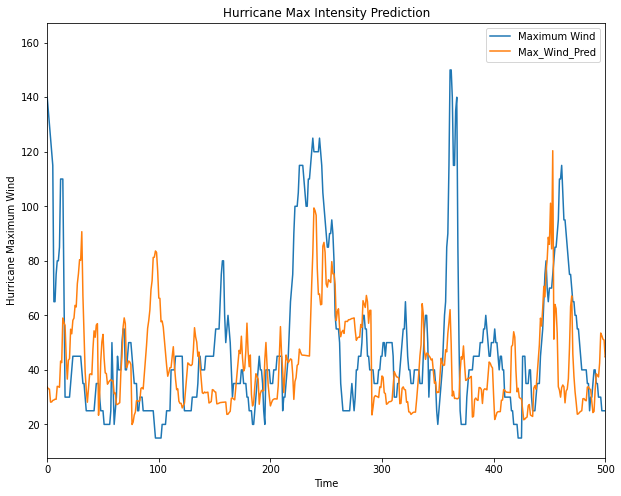

In [63]:
df_pred = df_final[['Maximum Wind', 'Max_Wind_Pred']]

df_pred.plot()

plt.xlim([0, 500])
plt.title('Hurricane Max Intensity Prediction')
plt.xlabel('Time')
plt.ylabel('Hurricane Maximum Wind')
plt.show()
